# Fake Job Description Prediction

This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs. The dataset can be used to create classification models which can learn the job descriptions which are fraudulent.



# Importing all necessary Libraries

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# All text preprocessing libraries
import re 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_tokenizer=RegexpTokenizer(r"\w+")

#libraries for training the models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 




[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
df.shape

(17880, 18)

In [4]:
df.columns
df_columns = df.columns.tolist()

In [5]:
dataTypeSeries = df.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


In [6]:
df[df_columns].isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
df = df.replace(np.nan, '', regex=True)

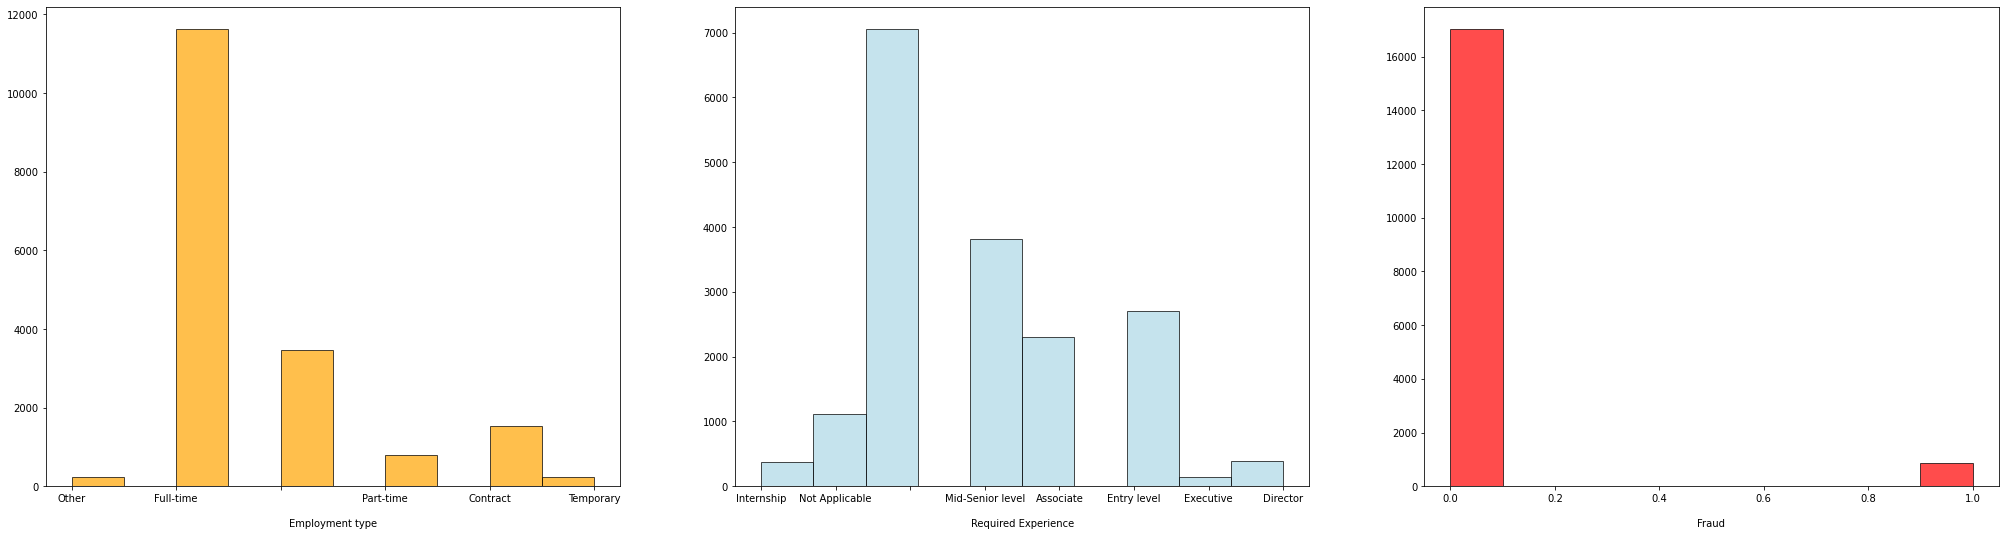

In [8]:
# Plots to see the distribution of the continuous features individually

plt.figure(figsize= (35,30))
plt.subplot(3,3,1)
plt.hist(df.employment_type, color='orange', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nEmployment type')

plt.subplot(3,3,2)
plt.hist(df.required_experience, color='lightblue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Experience')

plt.subplot(3,3,3)
plt.hist(df.fraudulent, color='red', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nFraud')


plt.show()

Full-time jobs are posted more comparatively to other type of employment. There are more jobs available that requires Mid-senior level Experience.

<AxesSubplot:xlabel='function', ylabel='count'>

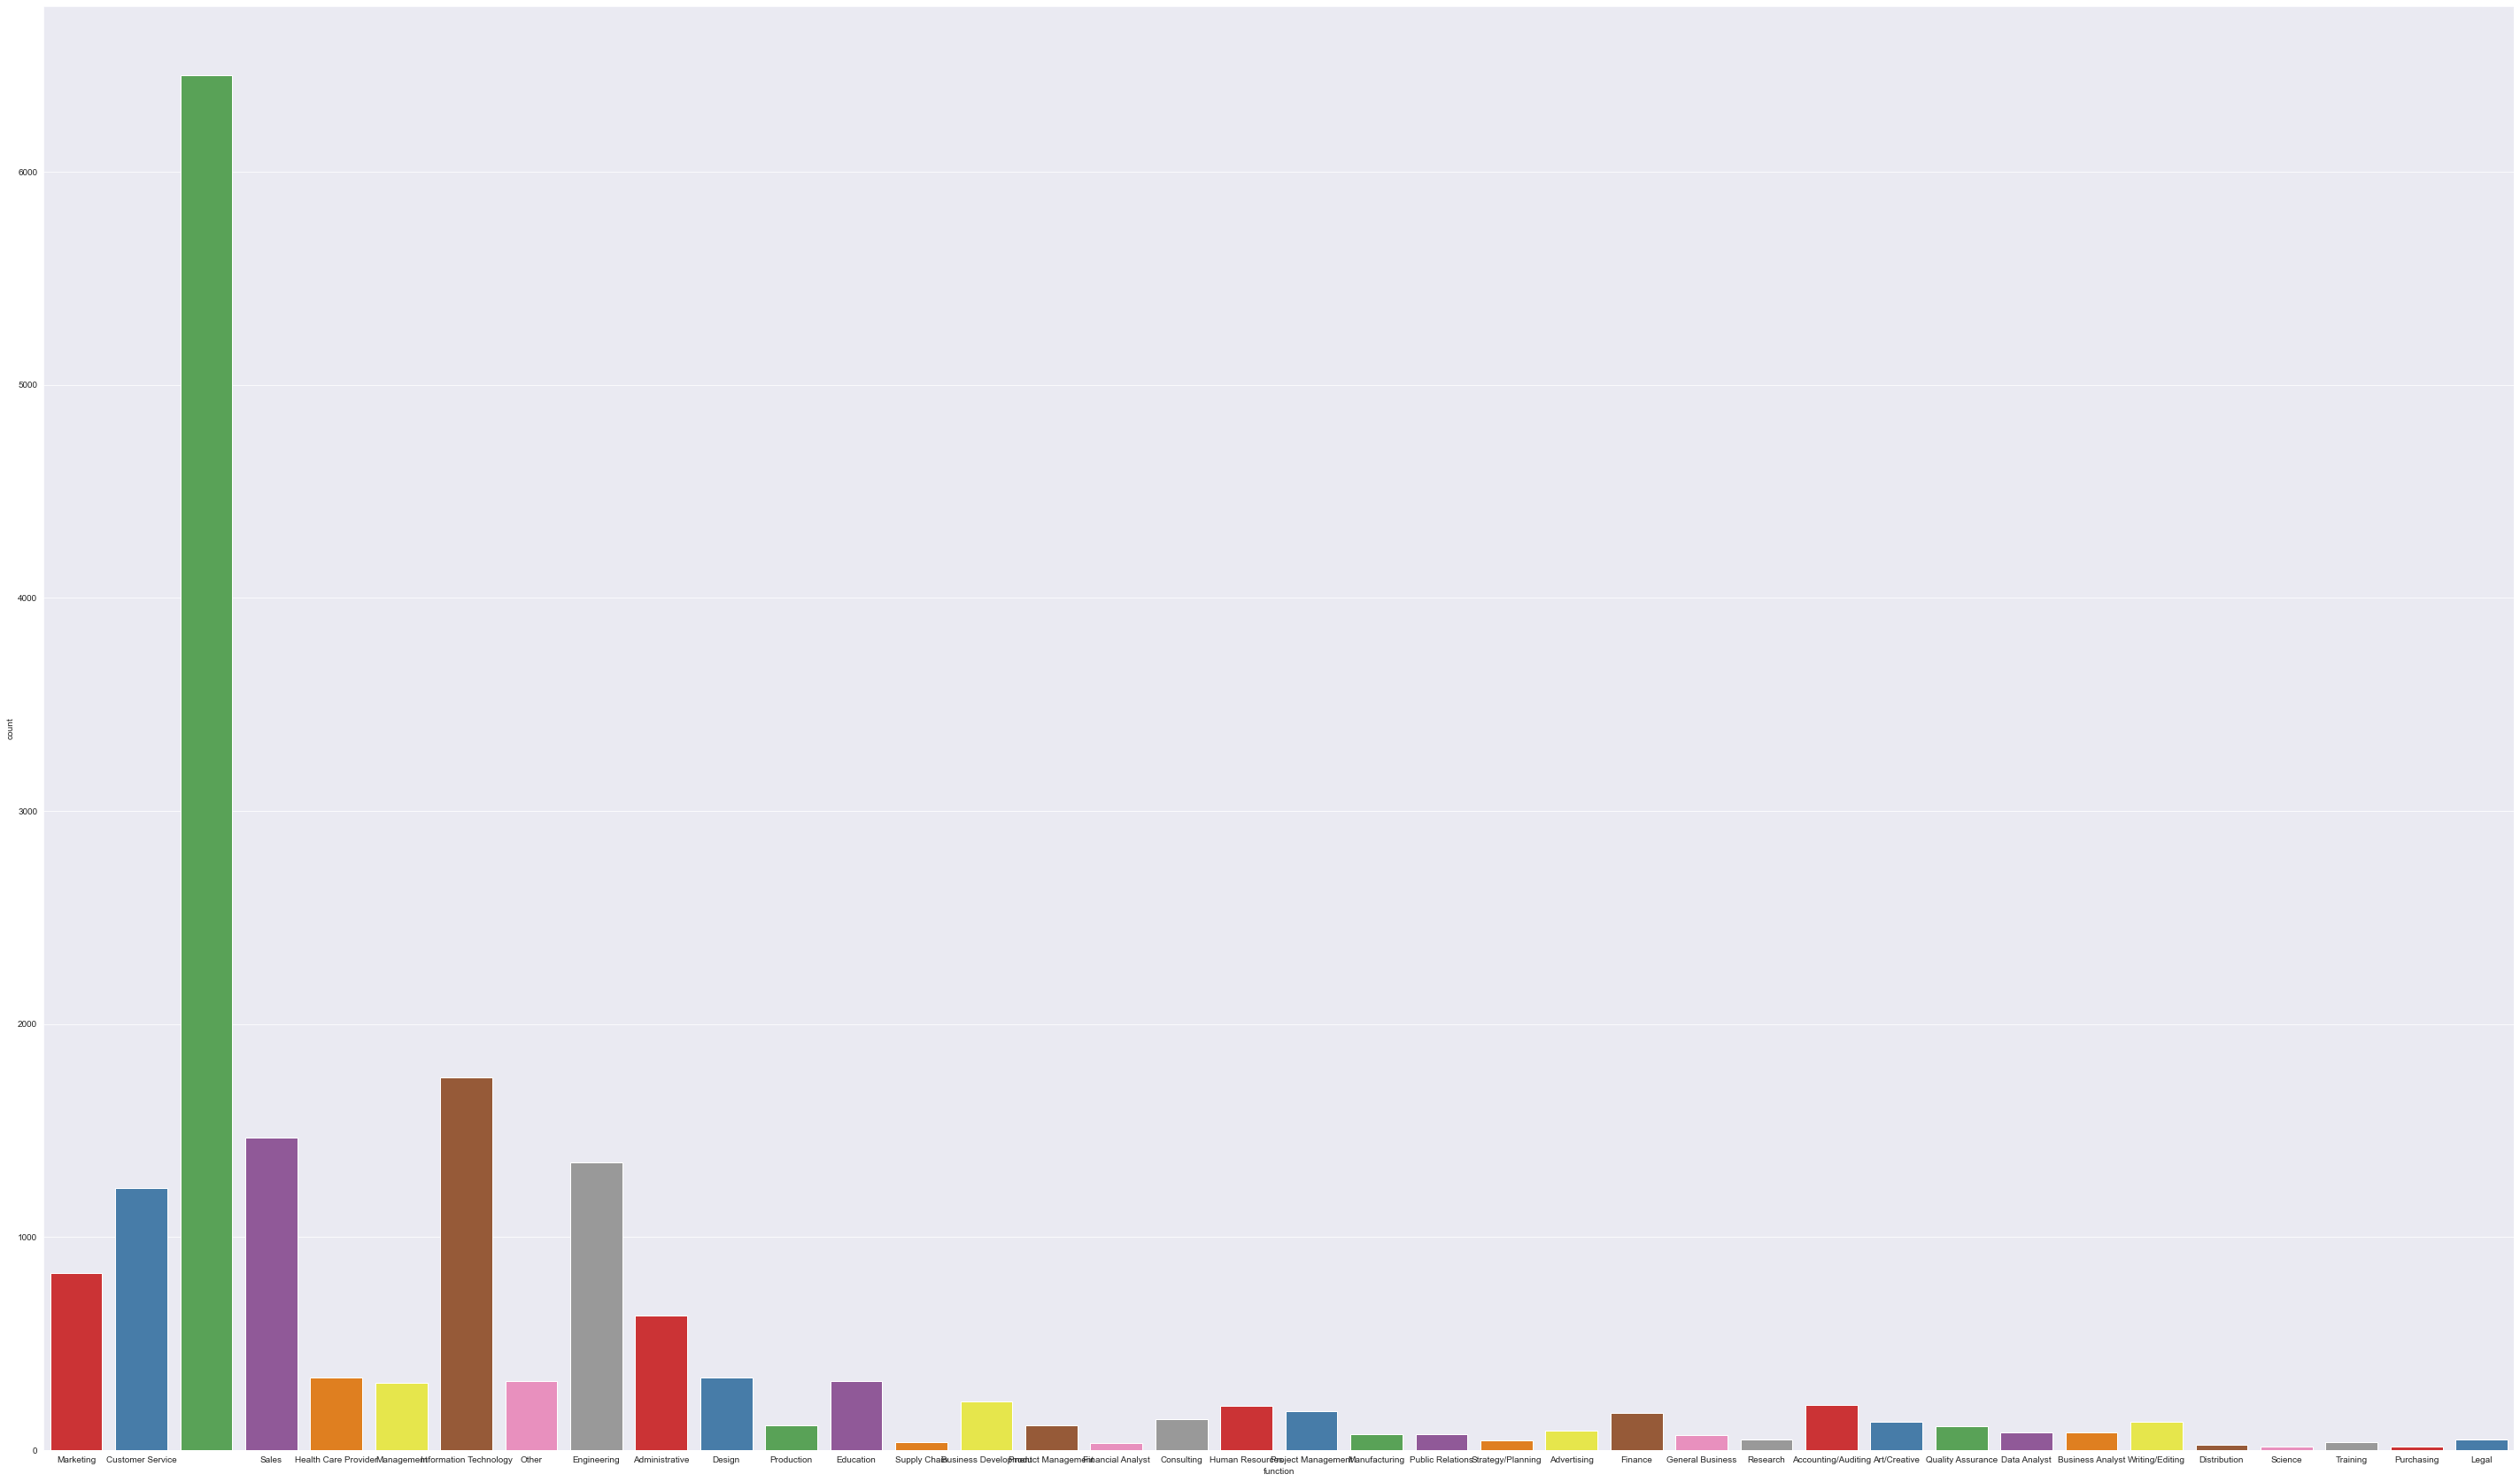

In [9]:
plt.figure(figsize=(50,30))
sns.set_style("darkgrid")
sns.countplot(x='function',data=df,palette='Set1')

There are maximum number of jobs are posted in IT field and minimum jobs are posted related to Distribution. Jobs in Sales,IT,Marketing,Engineering,Customer Service,Administrative are most in demand jobs.



# Data Distributions
If lots of values, plot both head and tail to get sense of range

In [10]:
# Function to plot distribution of variables
# Inputs:
    # col: feature we want to graph distribution of
    # title: title of plot
    # boolean: True if variable is boolean -> different formatting
    # tail: True if plot head and tail of distribution if many values. False if plot all values
def hist_plt(col, title, boolean = False, tail = False):
    
    # 1 vs 2 plots in the figure
    if tail:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        num = 10
    else:
        f, ax1 = plt.subplots()
        num = 1000
        
    # get value counts for distribution
    head = df[col].value_counts().head(num)
    
    # plot
    if boolean == False:
        ax1.bar(head.index, head)
        ax1.set_xticklabels(labels = head.index, rotation=90)
    # if boolean, need to sort in consistent No, Yes order rather than by value counts 
    else:
        bplt = df[col].value_counts()
        bplt = bplt.sort_index() # need to be in No, Yes order
        ax1.bar(bplt.index, bplt)
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(labels = ['No', 'Yes'])
    
    # second plot if need to plot distribution tail
    if tail:
        tail = df[col].value_counts().tail(10)
        ax2.bar(tail.index, tail)
        ax2.set_xticklabels(labels = tail.index, rotation=90)
        
    # title
    f.suptitle(title, fontsize=16)
    
    return ax1.get_figure()

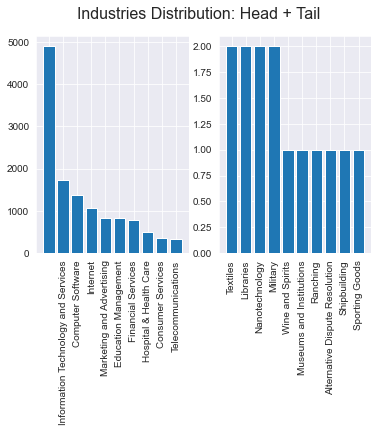

In [11]:
ind_dist = hist_plt('industry', 'Industries Distribution: Head + Tail', tail = True)

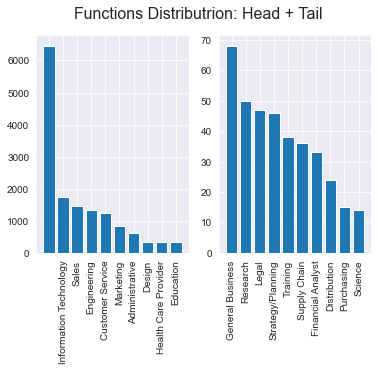

In [12]:
fun_dist = hist_plt('function', 'Functions Distributrion: Head + Tail', tail = True)

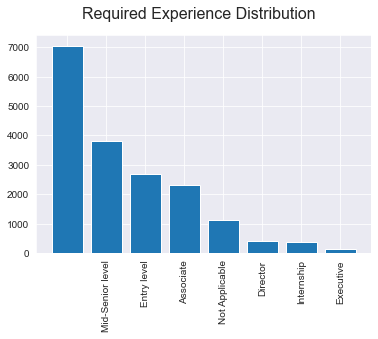

In [13]:
exp_dist = hist_plt('required_experience', 'Required Experience Distribution')

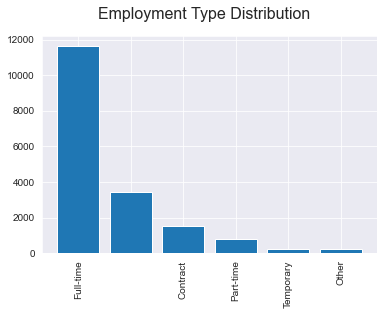

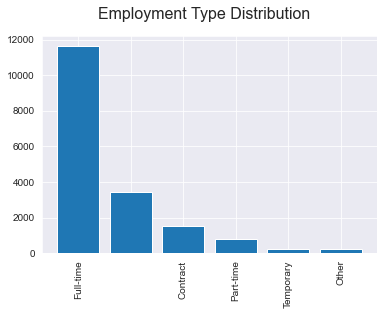

In [14]:
hist_plt('employment_type', 'Employment Type Distribution')

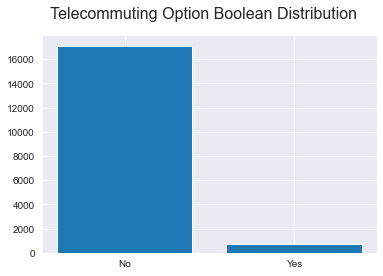

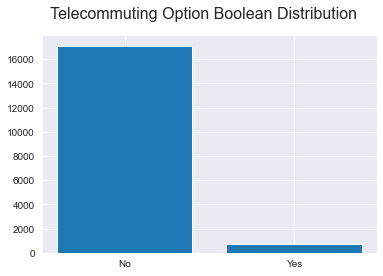

In [15]:
hist_plt('telecommuting', 'Telecommuting Option Boolean Distribution', boolean = True)

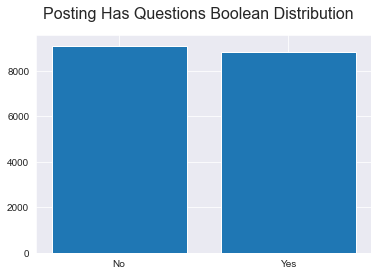

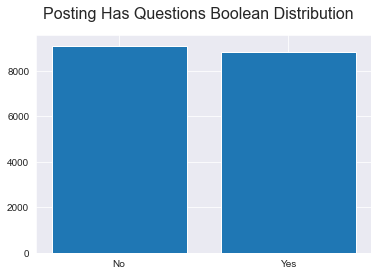

In [16]:
hist_plt('has_questions', 'Posting Has Questions Boolean Distribution', boolean = True)

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

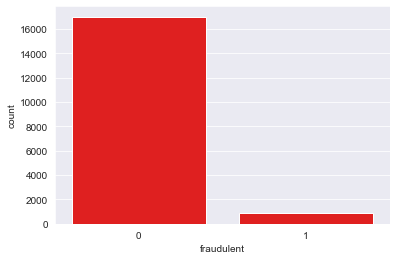

In [17]:
sns.countplot(x= 'fraudulent',data= df, color= 'red')

Clearly we can see that the given dataset is imbalanced dataset

Bar Plots of Metadata Frequency in Fraudulent Posts

In [18]:
# function to plot percent of postings of each value that are fake
# inputs:
    # col: feature we want to plot
    # titlecol: title for graph
    # boolean: True if boolean value -> different formatting
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame() # number fraud
    totcnt = df.groupby(col).job_id.count().to_frame() # number in general
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True) # merge
    frac['frac'] = frac.fraudulent / frac.job_id # fraction fraud
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    # take top 10 if not boolean
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    
    # xtick format
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    # title
    # if top 10 was not the full amount, say top 10 in title. Else, all values
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    # label
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

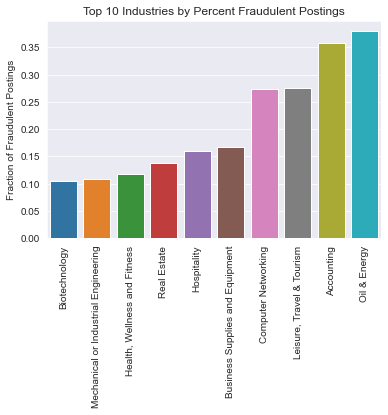

In [19]:
bar_plt('industry', 'Industries')

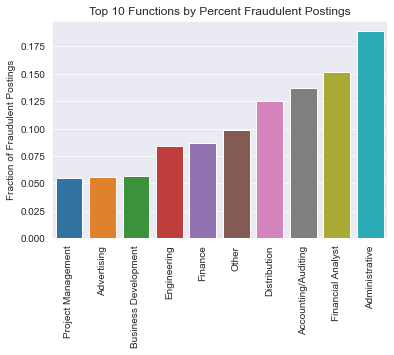

In [20]:
bar_plt('function', 'Functions')

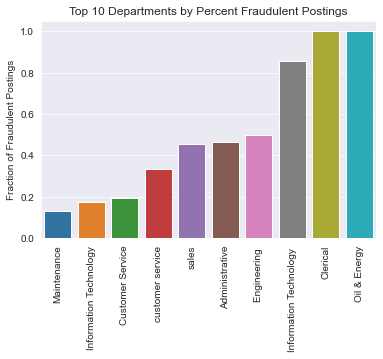

In [21]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

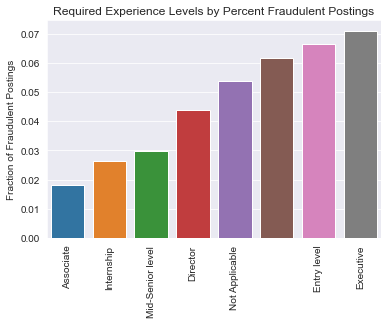

In [22]:
bar_plt('required_experience', 'Required Experience Levels')

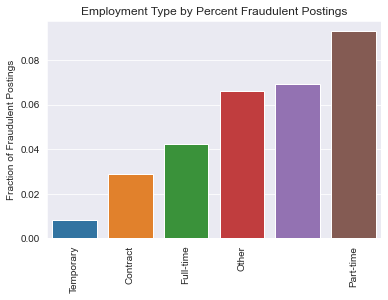

In [23]:
bar_plt('employment_type', 'Employment Type')

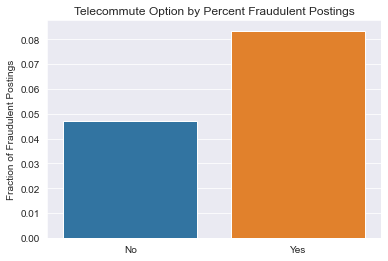

In [24]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

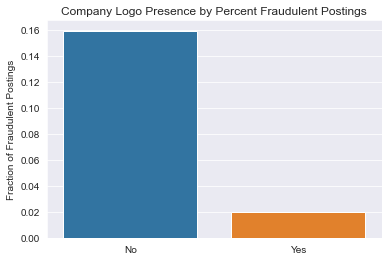

In [25]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

# Ques 1: Which is the job titles have most full time job opportunities and how many?

In [26]:
#Subsetting dataframe which have 'Full-time' emplyment type and also are not fruad.
df_jobs = df[(df['employment_type'] == 'Full-time') & (df['fraudulent']== 0)]

In [27]:
df_jobs.shape

(11130, 18)

In [28]:
#Checking the counts of each unique value
df_jobs['title'].value_counts()

Customer Service Associate        145
Software Engineer                  71
Account Manager                    64
Web Developer                      50
Customer Service Associate         40
                                 ... 
Nortel BCM Field Tech               1
Digital Marketing Officer           1
Visa Specialist                     1
DevOps / CI Engineer                1
Medicare Assistance Counselor       1
Name: title, Length: 7079, dtype: int64

In [29]:
df_jobs['title'].value_counts().max()

145

# Ans 1 : Job title 'Customer Service Associate ' has 145 opportunities for a full time job.

In [30]:
df.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0


# Que 2 : Which industry have the maximum number of fake job postings?

In [31]:
#Only including rows which are fake job postings.
df_industry = df[df['fraudulent']== 1]

In [32]:
df_industry.shape

(866, 18)

In [33]:
#Checking each unique value counts of industry.
df_industry['industry'].value_counts()

                               275
Oil & Energy                   109
Accounting                      57
Hospital & Health Care          51
Marketing and Advertising       45
                              ... 
Civic & Social Organization      1
Broadcast Media                  1
Public Safety                    1
Security and Investigations      1
Medical Devices                  1
Name: industry, Length: 63, dtype: int64

# Ans 2 : Industry with, maximum no. of fake job postings : Oil & energy

In [34]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

4.8434% (Approx 5%) Fake job post.


In [35]:
df['text'] = df[['title', 'department','company_profile','description','requirements','benefits']].apply(lambda x: ' '.join(x), axis = 1) 

In [36]:
df.drop(['job_id', 'location','title','salary_range' ,'department','salary_range','company_profile','description','requirements','benefits'], axis=1, inplace=True)

In [37]:
df.columns
df_columns = df.columns.tolist()

# Dummy Variables
All variables are categorical, create dummies and drop one level to avoid collinearity
For country, many values so only create dummy if more than 100 posts in that country

In [38]:
from sklearn.preprocessing import LabelEncoder
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
  df[i] = lb_make.fit_transform(df[i])

In [39]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,0,1,0,3,5,0,0,23,0,"Marketing Intern Marketing We're Food52, and w..."
1,0,1,0,2,7,0,76,8,0,Customer Service - Cloud Video Production Succ...
2,0,1,0,0,0,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor...
3,0,1,0,2,6,2,23,32,0,Account Executive - Washington DC Sales Our pa...
4,0,1,1,2,6,2,52,17,0,Bill Review Manager SpotSource Solutions LLC ...


In [40]:
df_columns = df_columns[-1:] + df_columns[:-1]
df = df[df_columns]
df.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"Marketing Intern Marketing We're Food52, and w...",0,1,0,3,5,0,0,23,0
1,Customer Service - Cloud Video Production Succ...,0,1,0,2,7,0,76,8,0
2,Commissioning Machinery Assistant (CMA) Valor...,0,1,0,0,0,0,0,0,0
3,Account Executive - Washington DC Sales Our pa...,0,1,0,2,6,2,23,32,0
4,Bill Review Manager SpotSource Solutions LLC ...,0,1,1,2,6,2,52,17,0


# Text Processing

In [41]:
  def clean_text(text, ):
        if text is not None:
        #exclusions = ['RE:', 'Re:', 're:']
        #exclusions = '|'.join(exclusions)
                text = re.sub(r'[0-9]+','',text)
                text =  text.lower()
                text = re.sub('re:', '', text)
                text = re.sub('-', '', text)
                text = re.sub('_', '', text)
                text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
                text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)
        # Remove text between square brackets
                text =re.sub('\[[^]]*\]', '', text)
        # removes punctuation
                text = re.sub(r'[^\w\s]','',text)
                text = re.sub(r'\n',' ',text)
                text = re.sub(r'[0-9]+','',text)
                #text = re.sub(r'[0-9]+','',text)
        # strip html 
                p = re.compile(r'<.*?>')
                text = re.sub(r"\'ve", " have ", text)
                text = re.sub(r"can't", "cannot ", text)
                text = re.sub(r"n't", " not ", text)
                text = re.sub(r"I'm", "I am", text)
                text = re.sub(r" m ", " am ", text)
                text = re.sub(r"\'re", " are ", text)
                text = re.sub(r"\'d", " would ", text)
                text = re.sub(r"\'ll", " will ", text)
        
                text = p.sub('', text)

        def tokenize_text(text,tokenizer=default_tokenizer):
            token = default_tokenizer.tokenize(text)
            return token
        
        def remove_stopwords(text, stop_words=default_stopwords):
            tokens = [w for w in tokenize_text(text) if w not in stop_words]
            return ' '.join(tokens)

        def stem_text(text, stemmer=default_stemmer):
            tokens = tokenize_text(text)
            return ' '.join([stemmer.stem(t) for t in tokens])

        text = stem_text(text) # stemming
        text = remove_stopwords(text) # remove stopwords
        #text.strip(' ') # strip whitespaces again?

        return text

In [42]:
df['text'] = df['text'].apply(clean_text)

In [43]:
df['text'].head()

0    market intern market food weve creat groundbre...
1    custom servic cloud video product success seco...
2    commiss machineri assist cma valor servic prov...
3    account execut washington dc sale passion impr...
4    bill review manag spotsourc solut llc global h...
Name: text, dtype: object

# Conversion of text to Vectors

# Method 1 :  Avg Word2Vec

In [44]:
Y = df.iloc[:,-1]
X = df.iloc[:,:-1]

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [46]:
X_train.head()

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
13016,net develop c sql soa ssi albani ny provid ful...,0,0,0,2,0,0,23,0
15068,ne busi admin apprenticeship avail na year old...,0,1,1,0,7,5,0,0
3147,softwar engin intern recombin provid clinic ge...,0,1,0,4,5,2,10,13
9157,senior test engin european dynam urlcffaceabda...,0,1,0,2,6,2,23,19
5224,graduat program sale work cubic seem like idea...,0,1,1,2,3,2,59,32


In [47]:
# Train your own Word2Vec model using your own text corpus
i=0
train_sent_list=[]
for sent in X_train['text'].values:
    train_sent_list.append(sent.split())
    

i=0
test_sent_list=[]
for sent in X_test['text'].values:
    test_sent_list.append(sent.split())

In [48]:
from gensim.models import Word2Vec

train_w2v_model= Word2Vec(train_sent_list,min_count=5,size=50, workers=4)
train_w2v_words = list(train_w2v_model.wv.vocab)

test_w2v_model= Word2Vec(test_sent_list,min_count=5,size=50, workers=4)
test_w2v_words = list(test_w2v_model.wv.vocab)

In [49]:
#Training data for average w2v

from tqdm import tqdm

train_sent_vectors = []
for sent in tqdm(train_sent_list):
    train_sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in train_w2v_words:
            vec = train_w2v_model.wv[word]
            train_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        train_sent_vec /= cnt_words
    train_sent_vectors.append(train_sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 13410/13410 [07:17<00:00, 30.68it/s]

13410
50


In [50]:
#Test data for average w2v

test_sent_vectors = []
for sent in tqdm(test_sent_list):
    test_sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in test_w2v_words:
            vec = test_w2v_model.wv[word]
            test_sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        test_sent_vec /= cnt_words
    test_sent_vectors.append(test_sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 4470/4470 [01:26<00:00, 51.46it/s]

4470
50


# Method 2: Tf- IDF 

In [136]:
df

,text,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,market intern market food weve creat groundbre...,0,1,0,3,5,0,0,23,0
1,custom servic cloud video product success seco...,0,1,0,2,7,0,76,8,0
2,commiss machineri assist cma valor servic prov...,0,1,0,0,0,0,0,0,0
3,account execut washington dc sale passion impr...,0,1,0,2,6,2,23,32,0
4,bill review manag spotsourc solut llc global h...,0,1,1,2,6,2,52,17,0
...,...,...,...,...,...,...,...,...,...,...
17875,account director distribut sale vend look awes...,0,1,1,2,6,0,23,32,0
17876,payrol account account weblinc ecommerc platfo...,0,1,1,2,6,2,62,1,0
17877,project cost control staff engin cost control ...,0,0,0,2,0,0,0,0,0
17878,graphic design nemsia studio look experienc vi...,0,0,1,1,7,7,49,10,0


In [44]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1)

# Data Standardization

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[['employment_type', 'required_experience', 'required_education','industry','function']] = StandardScaler().fit_transform(df[['employment_type', 'required_experience', 'required_education','industry','function']])


In [56]:
df

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,1.290338,0.965807,-0.756563,-1.115956,1.063009,0
1,0,1,0,0.321040,1.731617,-0.756563,1.041755,-0.275616,0
2,0,1,0,-1.617558,-0.948718,-0.756563,-1.115956,-0.989549,0
3,0,1,0,0.321040,1.348712,-0.086046,-0.462964,1.866184,0
4,0,1,1,0.321040,1.348712,-0.086046,0.360373,0.527559,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,0.321040,1.348712,-0.756563,-0.462964,1.866184,0
17876,0,1,1,0.321040,1.348712,-0.086046,0.644282,-0.900308,0
17877,0,0,0,0.321040,-0.948718,-0.756563,-1.115956,-0.989549,0
17878,0,0,1,-0.648259,1.731617,1.590246,0.275200,-0.097133,0


In [47]:
main_df.head()

,abil,account,also,amp,applic,base,benefit,best,build,busi,...,year,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.000000,0.000000,0.116434,0.102818,0.000000,0.000000,0.000000,0.119893,0.000000,0.091077,...,0.000000,0,1,0,3,5,0,0,23,0
1,0.000000,0.041469,0.033522,0.059203,0.000000,0.061404,0.000000,0.000000,0.000000,0.104886,...,0.000000,0,1,0,2,7,0,76,8,0
2,0.000000,0.000000,0.000000,0.092825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,1,0,0,0,0,0,0,0
3,0.039152,0.566401,0.000000,0.000000,0.000000,0.000000,0.089800,0.000000,0.118249,0.293025,...,0.058842,0,1,0,2,6,2,23,32,0
4,0.000000,0.109922,0.000000,0.000000,0.086042,0.000000,0.095852,0.182991,0.000000,0.069505,...,0.062808,0,1,1,2,6,2,52,17,0


In [57]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

In [58]:
main_df

,abil,account,also,amp,applic,base,benefit,best,build,busi,...,year,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0.000000,0.000000,0.116434,0.102818,0.000000,0.000000,0.000000,0.119893,0.000000,0.091077,...,0.000000,0,1,0,3,5,0,0,23,0
1,0.000000,0.041469,0.033522,0.059203,0.000000,0.061404,0.000000,0.000000,0.000000,0.104886,...,0.000000,0,1,0,2,7,0,76,8,0
2,0.000000,0.000000,0.000000,0.092825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,1,0,0,0,0,0,0,0
3,0.039152,0.566401,0.000000,0.000000,0.000000,0.000000,0.089800,0.000000,0.118249,0.293025,...,0.058842,0,1,0,2,6,2,23,32,0
4,0.000000,0.109922,0.000000,0.000000,0.086042,0.000000,0.095852,0.182991,0.000000,0.069505,...,0.062808,0,1,1,2,6,2,52,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.038962,0.153725,0.082843,0.146310,0.000000,0.037937,0.000000,0.085304,0.117677,0.097202,...,0.000000,0,1,1,2,6,0,23,32,0
17876,0.090792,0.776149,0.048262,0.127853,0.046733,0.088404,0.052061,0.000000,0.000000,0.000000,...,0.068227,0,1,1,2,6,2,62,1,0
17877,0.000000,0.174196,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055073,...,0.099533,0,0,0,2,0,0,0,0,0
17878,0.000000,0.000000,0.000000,0.205171,0.000000,0.106399,0.000000,0.000000,0.000000,0.000000,...,0.000000,0,0,1,1,7,7,49,10,0


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [60]:
y_train.value_counts()

0    12767
1      643
Name: fraudulent, dtype: int64

# Balancing the Dataset


SMOTE: class imbalance
SMOTE sampling on the training data such that even number of observations with each class
This funciton also does 80/20 train/test split

SMOTE: synethic minority over-sampling technique
Synthesize new examples for the minority class rateher than oversample, which doesn't add any new information.

"… SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b"

In [61]:
from imblearn.over_sampling import SMOTE
smk  = SMOTE()
X_res,Y_res= smk.fit_resample(X_train,y_train)

In [62]:
X_res.shape,Y_res.shape

((25534, 108), (25534,))

In [63]:
Y_res.value_counts()

0    12767
1    12767
Name: fraudulent, dtype: int64

<AxesSubplot:ylabel='fraudulent'>

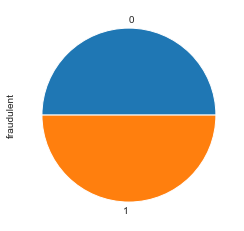

In [64]:
Y_res.value_counts().plot(kind="pie")

# Applying Smote on the vectors of Word2Vec vectors

In [53]:
from imblearn.over_sampling import SMOTE
smk  = SMOTE()
X_bal,Y_bal= smk.fit_resample(train_sent_vectors,y_train)

In [55]:
Y_bal.value_counts()

0    12767
1    12767
Name: fraudulent, dtype: int64

Data is Balanced

# Ensemble Tree Models

# Random Forest With Avg Word2Vec

In [56]:
Rand = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=Rand.fit(X_bal,Y_bal)

In [60]:
rfc_predict = model.predict(test_sent_vectors)

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,rfc_predict)

0.9501118568232663

In [63]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4247
           1       0.00      0.00      0.00       223

    accuracy                           0.95      4470
   macro avg       0.48      0.50      0.49      4470
weighted avg       0.90      0.95      0.93      4470



# Random Forest with TF-IDF

In [72]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_res,Y_res)

In [74]:
rfc_predict = rfc.predict(X_test)

In [75]:
accuracy_score(y_test,rfc_predict)

0.9758389261744966

In [76]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4247
           1       0.87      0.61      0.72       223

    accuracy                           0.98      4470
   macro avg       0.92      0.80      0.85      4470
weighted avg       0.97      0.98      0.97      4470



In [77]:
confusion_matrix(y_test, rfc_predict)

array([[4226,   21],
       [  87,  136]], dtype=int64)

Comparison : Clearly we can see that Random Forest gives higher accuracy for TF-IDF Vectorization form. 

# Xg_Boost with TF-IDF

In [187]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
clf = XGBClassifier()

clf.fit(X_res, Y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [188]:
y_Pred_xgbi= clf.predict(X_test)

In [189]:
accuracy_score(y_test, y_Pred_xgbi)

0.976062639821029

In [190]:
print(classification_report(y_test,y_Pred_xgbi ))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4247
           1       0.80      0.70      0.74       223

    accuracy                           0.98      4470
   macro avg       0.89      0.85      0.87      4470
weighted avg       0.97      0.98      0.98      4470



In [191]:
cm = confusion_matrix(y_test,y_Pred_xgb)
print("confusion matrix of Decision tress:\n", cm, "\n")


confusion matrix of Decision tress:
 [[4207   40]
 [  67  156]] 



# Xg-Boost with Avg Word2Vec

In [192]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
clf = XGBClassifier(objective='binary:logistic')

clf.fit(X_bal, Y_bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [193]:
y_Pred_xgb= clf.predict(test_sent_vectors)

In [196]:
accuracy_score(y_test, y_Pred_xgb)

0.976062639821029

In [194]:
print(classification_report(y_test,y_Pred_xgb ))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4247
           1       0.80      0.70      0.74       223

    accuracy                           0.98      4470
   macro avg       0.89      0.85      0.87      4470
weighted avg       0.97      0.98      0.98      4470



In [195]:

cm = confusion_matrix(y_test,y_Pred_xgb)
print("confusion matrix of Decision tress:\n", cm, "\n")


confusion matrix of Decision tress:
 [[4207   40]
 [  67  156]] 



Comparison : Clearly we can see that Xg-Boost approximately same accuracy accuracy for Both TF-IDF and Avg Word2Vec form.

# Decision Tree with Avg Word2Vec

In [67]:
from sklearn.tree import DecisionTreeClassifier
dsci= DecisionTreeClassifier()
dsci.fit(X_bal,Y_bal)

DecisionTreeClassifier()

In [68]:
y_Pred_dsci= dsci.predict(test_sent_vectors)

In [69]:
accuracy_score(y_test, y_Pred_dsci)

0.7053691275167785

In [70]:
print(classification_report(y_test,y_Pred_dsci ))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      4247
           1       0.07      0.40      0.12       223

    accuracy                           0.71      4470
   macro avg       0.51      0.56      0.47      4470
weighted avg       0.91      0.71      0.79      4470



In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_Pred_dsci)
print("confusion matrix of Decision tress:\n", cm, "\n")

confusion matrix of Decision tress:
 [[3063 1184]
 [ 133   90]] 



# Decision Tree with TF-IDF

In [78]:
from sklearn.tree import DecisionTreeClassifier
dsc= DecisionTreeClassifier()
dsc.fit(X_res,Y_res)

DecisionTreeClassifier()

In [163]:
dsc.score(X_res,Y_res)

1.0

In [164]:
dsc.score(X_test,y_test)

0.9395973154362416

In [79]:
y_Pred_dsc= dsc.predict(X_test)

In [80]:
accuracy_score(y_test,y_Pred_dsc)

0.9413870246085011

In [166]:
print(classification_report(y_test,y_Pred_dsc ))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4247
           1       0.43      0.61      0.50       223

    accuracy                           0.94      4470
   macro avg       0.70      0.78      0.73      4470
weighted avg       0.95      0.94      0.94      4470



In [167]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test,y_Pred_dsc)
print("confusion matrix of Decision tress:\n", cm, "\n")


confusion matrix of Decision tress:
 [[4065  182]
 [  88  135]] 



Comparison : Clearly we can see that Decision Tree gives higher accuracy for TF-IDF Vectorization form.

# Logistic Regression with Avg Word2Vec

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# fit data using logistic regression
log_regress = LogisticRegression()
log_regress.fit(X_bal,Y_bal)

LogisticRegression()

In [73]:
# predict output of the test data set
y_pred = log_regress.predict(test_sent_vectors)

In [74]:
# get accuracy
print("Testing accuracy score of Logistic Regression:", accuracy_score(y_pred, y_test), "\n")

Testing accuracy score of Logistic Regression: 0.9463087248322147 



In [75]:
# creating a confusion matrix 
cm = confusion_matrix(y_test,y_pred)
print("confusion matrix of Logistic Regression:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test,y_pred), "\n")

confusion matrix of Logistic Regression:
 [[4229   18]
 [ 222    1]] 

classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      4247
           1       0.05      0.00      0.01       223

    accuracy                           0.95      4470
   macro avg       0.50      0.50      0.49      4470
weighted avg       0.91      0.95      0.92      4470
 



# Logistic Regression with TF-IDF

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# fit data using logistic regression
log_regress = LogisticRegression()
log_regress.fit(X_res,Y_res)


LogisticRegression()

In [169]:
# predict output of the test data set
y_pred = log_regress.predict(X_test)



In [170]:
# get accuracy
print("Testing accuracy score of Logistic Regression:", accuracy_score(y_pred, y_test), "\n")


Testing accuracy score of Logistic Regression: 0.8429530201342282 



In [171]:
# creating a confusion matrix 
cm = confusion_matrix(y_test,y_pred)
print("confusion matrix of Logistic Regression:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test,y_pred), "\n")

confusion matrix of Logistic Regression:
 [[3585  662]
 [  40  183]] 

classification report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      4247
           1       0.22      0.82      0.34       223

    accuracy                           0.84      4470
   macro avg       0.60      0.83      0.63      4470
weighted avg       0.95      0.84      0.88      4470
 



Comparison : Clearly we can see that Logistic Regression gives higher accuracy for Avg Word2Vec Vectorization form.

# Support Vector Machine With Avg Word2Vec

In [76]:
from sklearn.svm import SVC

# fit data using SVC
svc = SVC(kernel='rbf')
svc.fit(X_bal, Y_bal)

SVC()

In [77]:
# predict output of the test data set
predicted = svc.predict(test_sent_vectors)

In [78]:
# get accuracy
print("accuracy score of Support Vector Machine:", accuracy_score(predicted, y_test), "\n")


accuracy score of Support Vector Machine: 0.9503355704697987 



In [79]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, predicted)
print("confusion matrix of SVM:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test, predicted), "\n")

confusion matrix of SVM:
 [[4246    1]
 [ 221    2]] 

classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      4247
           1       0.67      0.01      0.02       223

    accuracy                           0.95      4470
   macro avg       0.81      0.50      0.50      4470
weighted avg       0.94      0.95      0.93      4470
 



# Support Vector Machine with TF-IDF

In [172]:
from sklearn.svm import SVC

# fit data using SVC
svc = SVC(kernel='rbf')
svc.fit(X_res, Y_res)


SVC()

In [173]:
# predict output of the test data set
predicted = svc.predict(X_test)

In [174]:
# get accuracy
print("accuracy score of Support Vector Machine:", accuracy_score(predicted, y_test), "\n")

accuracy score of Support Vector Machine: 0.9505592841163311 



In [176]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, predicted)
print("confusion matrix of SVM:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test, predicted), "\n")

confusion matrix of SVM:
 [[4072  175]
 [  46  177]] 

classification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      4247
           1       0.50      0.79      0.62       223

    accuracy                           0.95      4470
   macro avg       0.75      0.88      0.79      4470
weighted avg       0.96      0.95      0.96      4470
 



Let's try hyperparameter tuning in order to increase the accuracy

In [65]:
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1],'gamma':[0.1,0.01,0.001]}
grid= GridSearchCV(SVC(),param_grid, verbose=3, n_jobs=-1)
grid.fit(X_res,Y_res)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1], 'gamma': [0.1, 0.01, 0.001]},
             verbose=3)

In [66]:
grid.best_params_

{'C': 1, 'gamma': 0.1}

In [70]:
model_new=SVC(kernel='rbf',C=1, gamma=0.1)
model_new.fit(X_res,Y_res)

SVC(C=1, gamma=0.1)

In [75]:
model_new.score(X_test,y_test)

0.9527964205816555

Comparison : Clearly we can see that SVM gives higher accuracy for TF-IDF Vectorization form.

# K-Nearest Neighbors with Avg Word2Vec

In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
from sklearn.metrics import accuracy_score, confusion_matrix
knn.fit(X_bal,Y_bal)

KNeighborsClassifier()

In [81]:
y_pred = knn.predict(test_sent_vectors)

In [82]:
print("The accuracy score is : ", accuracy_score(y_test,y_pred))

The accuracy score is :  0.8353467561521253


In [83]:
# creating a confusion matrix 
cm = confusion_matrix(y_test,y_pred)
print("confusion matrix of KNN:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test, y_pred), "\n")

confusion matrix of KNN:
 [[3664  583]
 [ 153   70]] 

classification report:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      4247
           1       0.11      0.31      0.16       223

    accuracy                           0.84      4470
   macro avg       0.53      0.59      0.53      4470
weighted avg       0.92      0.84      0.87      4470
 



# K-Nearest Neighbors with TF-IDF

In [177]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
from sklearn.metrics import accuracy_score, confusion_matrix
knn.fit(X_res,Y_res)

KNeighborsClassifier()

In [178]:
y_pred = knn.predict(X_test)

In [180]:
print("The accuracy score is : ", accuracy_score(y_test,y_pred))

The accuracy score is :  0.8923937360178971


In [181]:

# creating a confusion matrix 
cm = confusion_matrix(y_test,y_pred)
print("confusion matrix of KNN:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test, y_pred), "\n")

confusion matrix of KNN:
 [[3786  461]
 [  20  203]] 

classification report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      4247
           1       0.31      0.91      0.46       223

    accuracy                           0.89      4470
   macro avg       0.65      0.90      0.70      4470
weighted avg       0.96      0.89      0.92      4470
 



Let's try to increase the accuracy by using hyperparameter tuning.

In [63]:
from sklearn.model_selection import GridSearchCV
param_grid = { 'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
               'leaf_size' : [18,20,25,27,30,32,34],
               'n_neighbors' : [3,5,7,9,10,11,12,13]
              }

gridsearch = GridSearchCV(knn, param_grid,verbose=3)
gridsearch.fit(X_res,Y_res)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
[CV 1/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3;, score=0.955 total time=   6.3s
[CV 2/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3;, score=0.958 total time=   4.9s
[CV 3/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3;, score=0.963 total time=   5.3s
[CV 4/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3;, score=0.952 total time=   4.8s
[CV 5/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=3;, score=0.953 total time=   6.5s
[CV 1/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5;, score=0.948 total time=   5.5s
[CV 2/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5;, score=0.948 total time=   5.6s
[CV 3/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5;, score=0.955 total time=   5.6s
[CV 4/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5;, score=0.939 total time=   5.2s
[CV 5/5] END algorithm=ball_tree, leaf_size=18, n_neighbors=5;, score=0.948 total 

[CV 2/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=5;, score=0.948 total time=   5.3s
[CV 3/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=5;, score=0.955 total time=   5.5s
[CV 4/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=5;, score=0.939 total time=   5.3s
[CV 5/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=5;, score=0.948 total time=   5.5s
[CV 1/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=7;, score=0.942 total time=   6.1s
[CV 2/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=7;, score=0.940 total time=   5.5s
[CV 3/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=7;, score=0.945 total time=   5.9s
[CV 4/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=7;, score=0.931 total time=   5.6s
[CV 5/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=7;, score=0.939 total time=   5.9s
[CV 1/5] END algorithm=ball_tree, leaf_size=25, n_neighbors=9;, score=0.933 total time=   6.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=25, n_

[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=7;, score=0.945 total time=   5.7s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=7;, score=0.931 total time=   5.4s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=7;, score=0.939 total time=   5.5s
[CV 1/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=9;, score=0.933 total time=   5.7s
[CV 2/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=9;, score=0.934 total time=   5.6s
[CV 3/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=9;, score=0.938 total time=   6.0s
[CV 4/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=9;, score=0.926 total time=   5.6s
[CV 5/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=9;, score=0.933 total time=   5.6s
[CV 1/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=10;, score=0.936 total time=   5.8s
[CV 2/5] END algorithm=ball_tree, leaf_size=30, n_neighbors=10;, score=0.936 total time=   5.6s
[CV 3/5] END algorithm=ball_tree, leaf_size=30, 

[CV 4/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=9;, score=0.926 total time=   5.3s
[CV 5/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=9;, score=0.933 total time=   5.4s
[CV 1/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=10;, score=0.936 total time=   5.4s
[CV 2/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=10;, score=0.936 total time=   5.3s
[CV 3/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=10;, score=0.939 total time=   5.6s
[CV 4/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=10;, score=0.928 total time=   5.3s
[CV 5/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=10;, score=0.937 total time=   5.3s
[CV 1/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=11;, score=0.929 total time=   6.0s
[CV 2/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=11;, score=0.928 total time=   5.6s
[CV 3/5] END algorithm=ball_tree, leaf_size=34, n_neighbors=11;, score=0.932 total time=   5.8s
[CV 4/5] END algorithm=ball_tree, leaf_siz

[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=11;, score=0.928 total time=   5.3s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=11;, score=0.932 total time=   5.6s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=11;, score=0.920 total time=   5.8s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=11;, score=0.927 total time=   5.6s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=12;, score=0.931 total time=   5.4s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=12;, score=0.929 total time=   5.6s
[CV 3/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=12;, score=0.935 total time=   5.6s
[CV 4/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=12;, score=0.922 total time=   5.6s
[CV 5/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=12;, score=0.929 total time=   5.6s
[CV 1/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=13;, score=0.923 total time=   5.8s
[CV 2/5] END algorithm=kd_tree, leaf_size=20, n_neighbors=13

[CV 5/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=12;, score=0.929 total time=   5.8s
[CV 1/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=13;, score=0.923 total time=   5.6s
[CV 2/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=13;, score=0.920 total time=   5.5s
[CV 3/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=13;, score=0.929 total time=   5.5s
[CV 4/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=13;, score=0.913 total time=   5.4s
[CV 5/5] END algorithm=kd_tree, leaf_size=27, n_neighbors=13;, score=0.923 total time=   5.4s
[CV 1/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3;, score=0.955 total time=   5.1s
[CV 2/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3;, score=0.958 total time=   5.0s
[CV 3/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3;, score=0.963 total time=   5.1s
[CV 4/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3;, score=0.952 total time=   5.2s
[CV 5/5] END algorithm=kd_tree, leaf_size=30, n_neighbors=3;, sc

[CV 3/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=3;, score=0.963 total time=   4.9s
[CV 4/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=3;, score=0.952 total time=   4.8s
[CV 5/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=3;, score=0.953 total time=   4.7s
[CV 1/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=5;, score=0.948 total time=   4.9s
[CV 2/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=5;, score=0.948 total time=   4.9s
[CV 3/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=5;, score=0.955 total time=   5.2s
[CV 4/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=5;, score=0.939 total time=   5.4s
[CV 5/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=5;, score=0.948 total time=   5.4s
[CV 1/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=7;, score=0.942 total time=   5.3s
[CV 2/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=7;, score=0.940 total time=   5.3s
[CV 3/5] END algorithm=kd_tree, leaf_size=34, n_neighbors=7;, score=0.

[CV 2/5] END algorithm=brute, leaf_size=20, n_neighbors=7;, score=0.940 total time=   4.7s
[CV 3/5] END algorithm=brute, leaf_size=20, n_neighbors=7;, score=0.945 total time=   4.5s
[CV 4/5] END algorithm=brute, leaf_size=20, n_neighbors=7;, score=0.931 total time=   4.7s
[CV 5/5] END algorithm=brute, leaf_size=20, n_neighbors=7;, score=0.939 total time=   4.5s
[CV 1/5] END algorithm=brute, leaf_size=20, n_neighbors=9;, score=0.933 total time=   4.8s
[CV 2/5] END algorithm=brute, leaf_size=20, n_neighbors=9;, score=0.934 total time=   4.8s
[CV 3/5] END algorithm=brute, leaf_size=20, n_neighbors=9;, score=0.938 total time=   5.1s
[CV 4/5] END algorithm=brute, leaf_size=20, n_neighbors=9;, score=0.926 total time=   4.8s
[CV 5/5] END algorithm=brute, leaf_size=20, n_neighbors=9;, score=0.933 total time=   4.4s
[CV 1/5] END algorithm=brute, leaf_size=20, n_neighbors=10;, score=0.936 total time=   5.1s
[CV 2/5] END algorithm=brute, leaf_size=20, n_neighbors=10;, score=0.936 total time=   4.

[CV 2/5] END algorithm=brute, leaf_size=27, n_neighbors=10;, score=0.936 total time=   4.8s
[CV 3/5] END algorithm=brute, leaf_size=27, n_neighbors=10;, score=0.939 total time=   4.5s
[CV 4/5] END algorithm=brute, leaf_size=27, n_neighbors=10;, score=0.928 total time=   5.1s
[CV 5/5] END algorithm=brute, leaf_size=27, n_neighbors=10;, score=0.937 total time=   4.6s
[CV 1/5] END algorithm=brute, leaf_size=27, n_neighbors=11;, score=0.929 total time=   4.8s
[CV 2/5] END algorithm=brute, leaf_size=27, n_neighbors=11;, score=0.928 total time=   4.6s
[CV 3/5] END algorithm=brute, leaf_size=27, n_neighbors=11;, score=0.932 total time=   4.3s
[CV 4/5] END algorithm=brute, leaf_size=27, n_neighbors=11;, score=0.920 total time=   4.5s
[CV 5/5] END algorithm=brute, leaf_size=27, n_neighbors=11;, score=0.927 total time=   4.7s
[CV 1/5] END algorithm=brute, leaf_size=27, n_neighbors=12;, score=0.931 total time=   5.0s
[CV 2/5] END algorithm=brute, leaf_size=27, n_neighbors=12;, score=0.929 total t

[CV 2/5] END algorithm=brute, leaf_size=32, n_neighbors=12;, score=0.929 total time=   5.0s
[CV 3/5] END algorithm=brute, leaf_size=32, n_neighbors=12;, score=0.935 total time=   4.7s
[CV 4/5] END algorithm=brute, leaf_size=32, n_neighbors=12;, score=0.922 total time=   4.5s
[CV 5/5] END algorithm=brute, leaf_size=32, n_neighbors=12;, score=0.929 total time=   4.8s
[CV 1/5] END algorithm=brute, leaf_size=32, n_neighbors=13;, score=0.923 total time=   5.4s
[CV 2/5] END algorithm=brute, leaf_size=32, n_neighbors=13;, score=0.920 total time=   4.9s
[CV 3/5] END algorithm=brute, leaf_size=32, n_neighbors=13;, score=0.929 total time=   4.4s
[CV 4/5] END algorithm=brute, leaf_size=32, n_neighbors=13;, score=0.913 total time=   4.6s
[CV 5/5] END algorithm=brute, leaf_size=32, n_neighbors=13;, score=0.923 total time=   4.4s
[CV 1/5] END algorithm=brute, leaf_size=34, n_neighbors=3;, score=0.955 total time=   3.6s
[CV 2/5] END algorithm=brute, leaf_size=34, n_neighbors=3;, score=0.958 total tim

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [18, 20, 25, 27, 30, 32, 34],
                         'n_neighbors': [3, 5, 7, 9, 10, 11, 12, 13]},
             verbose=3)

In [64]:
# let's see the  best parameters according to gridsearch
gridsearch.best_params_

{'algorithm': 'ball_tree', 'leaf_size': 18, 'n_neighbors': 3}

In [65]:
# we will use the best parameters in our k-NN algorithm and check if accuracy is increasing.
knn = KNeighborsClassifier(algorithm = 'ball_tree', leaf_size =18, n_neighbors =3)
knn.fit(X_res,Y_res)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=3)

In [66]:
knn.score(X_res,Y_res)

0.978342602020835

In [67]:
knn.score(X_test,y_test)

0.9234899328859061

Great, accuracy score has increased for our test data.

Comparison : Clearly we can see that KNN gives higher accuracy for TF-IDF Vectorization form.

# Naive Bayes With TF-IDF

In [90]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
model = GaussianNB()

In [91]:
model.fit(X_res,Y_res)

GaussianNB()

In [92]:
y_pred_nvt = model.predict(X_test)

In [93]:
accuracy_score(y_test,y_pred_nvt)

0.7715883668903804

In [95]:
# creating a confusion matrix 
cm = confusion_matrix(y_test,y_pred_nvt)
print("confusion matrix of KNN:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test, y_pred_nvt), "\n")

confusion matrix of KNN:
 [[3279  968]
 [  53  170]] 

classification report:
               precision    recall  f1-score   support

           0       0.98      0.77      0.87      4247
           1       0.15      0.76      0.25       223

    accuracy                           0.77      4470
   macro avg       0.57      0.77      0.56      4470
weighted avg       0.94      0.77      0.83      4470
 



# Naive Bayes with Avg Word2Vec

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
model = GaussianNB()

In [68]:
model.fit(X_bal,Y_bal)

GaussianNB()

In [86]:
y_pred_nvb = model.predict(test_sent_vectors)

In [87]:
accuracy_score(y_test,y_pred_nvb)

0.9534675615212528

In [88]:
# creating a confusion matrix 
cm = confusion_matrix(y_test,y_pred_nvb)
print("confusion matrix of KNN:\n", cm, "\n")

# create a classifcation report
print("classification report:\n", classification_report(y_test, y_pred_nvb), "\n")

confusion matrix of KNN:
 [[4237   10]
 [ 198   25]] 

classification report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      4247
           1       0.71      0.11      0.19       223

    accuracy                           0.95      4470
   macro avg       0.83      0.55      0.58      4470
weighted avg       0.94      0.95      0.94      4470
 



Comparison : Clearly we can see that Naive Bayes gives higher accuracy for Avg Word2Vec Vectorization form.

# Conclusion :

In [1]:
dicti= { 'Random Forest' : [97.50, 95.01], 'Xg-Boost':[97.06,97.05],'Decision Tree':[94.06,76],'Logistic Regression':[84.29,94.03],
       'Support Vector Machine':[95.05,95.03], 'KNN':[89.2,83.53],'Naive Bayes':[76.19,95.34]}

In [3]:
import pandas as pd
df= pd.DataFrame.from_dict(data=dicti,orient='index',columns= ['TF-IDF','Avg Word2Vec'])

In [4]:
df

,TF-IDF,Avg Word2Vec
Random Forest,97.50,95.01
Xg-Boost,97.06,97.05
Decision Tree,94.06,76.00
Logistic Regression,84.29,94.03
Support Vector Machine,95.05,95.03
KNN,89.20,83.53
Naive Bayes,76.19,95.34


Some Algorithm gives better Accuracy for TF-IDF and Some Algorithms gives better Accuracy for Word2Vec Vectorization form.